In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
with zipfile.ZipFile("C:/Users/USER/Downloads/events.csv.zip") as z:
    with z.open("events.csv")as f:
        df = pd.read_csv(f)
df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


Data Preprocessing

In [27]:
df.columns = df.columns.str.capitalize().str.strip()
df.columns
df.shape
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Event_time     885129 non-null  object 
 1   Event_type     885129 non-null  object 
 2   Product_id     885129 non-null  int64  
 3   Category_id    885129 non-null  int64  
 4   Category_code  648910 non-null  object 
 5   Brand          672765 non-null  object 
 6   Price          885129 non-null  float64
 7   User_id        885129 non-null  int64  
 8   User_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [29]:
df["Event_time"] = pd.to_datetime(df["Event_time"])
df["Category_code"] = df["Category_code"].astype("str")
df["User_id"] = df["User_id"].astype("str")
df["Brand"] = df["Brand"].fillna("Unknown")
df.tail(5)
df["Category_code"] = df["Category_code"].fillna("Unknown")
df["User_session"] = df["User_session"].fillna("Unkown")
df["Category_code"].dtype

dtype('O')

In [31]:
#Removing timezone info 
df["Event_time"] = df["Event_time"].dt.tz_localize(None)
df["Month"]  = df["Event_time"].dt.to_period("M")
df["Cohort_Month"] = df.groupby("User_id")["Month"].transform("min")
df.tail(5)

,Event_time,Event_type,Product_id,Category_id,Category_code,Brand,Price,User_id,User_session,Month,Cohort_Month
885124,2021-02-28 23:55:01,view,953226,2144415927553229037,nan,Unknown,219.94,1515915625611023730,FRLqIttxKU,2021-02,2021-02
885125,2021-02-28 23:58:05,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma,2021-02,2021-02
885126,2021-02-28 23:58:09,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd,2021-02,2021-02
885127,2021-02-28 23:58:14,view,888273,2144415921932861531,electronics.telephone,Unknown,10.16,1515915625611024030,9pCbKMIcSx,2021-02,2021-02
885128,2021-02-28 23:59:09,view,743182,2144415935631458761,construction.tools.soldering,kada,65.08,1515915625556087775,BejOXRngEW,2021-02,2020-12


In [33]:
def get_month(dtaframe,column):
    Year = dtaframe[column].dt.year
    Month = dtaframe[column].dt.month
    return Year,Month
Event_year, Event_month = get_month(df,"Month")
Cohort_year, Cohort_month = get_month(df,"Cohort_Month")
year_diff = Event_year - Cohort_year
month_diff = Event_month - Cohort_month
df["Cohort_index"] = year_diff * 12 + month_diff + 1
df.tail(5)

,Event_time,Event_type,Product_id,Category_id,Category_code,Brand,Price,User_id,User_session,Month,Cohort_Month,Cohort_index
885124,2021-02-28 23:55:01,view,953226,2144415927553229037,nan,Unknown,219.94,1515915625611023730,FRLqIttxKU,2021-02,2021-02,1
885125,2021-02-28 23:58:05,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma,2021-02,2021-02,1
885126,2021-02-28 23:58:09,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd,2021-02,2021-02,1
885127,2021-02-28 23:58:14,view,888273,2144415921932861531,electronics.telephone,Unknown,10.16,1515915625611024030,9pCbKMIcSx,2021-02,2021-02,1
885128,2021-02-28 23:59:09,view,743182,2144415935631458761,construction.tools.soldering,kada,65.08,1515915625556087775,BejOXRngEW,2021-02,2020-12,3


In [43]:
cohort = df.groupby(["Cohort_index","Cohort_Month"])["User_id"].nunique().reset_index()
cohort_pivot = cohort.pivot(index="Cohort_Month",columns="Cohort_index",values="User_id")
cohort_pivot

Cohort_index,1,2,3,4,5,6
Cohort_Month,,,,,,
2020-09,15334.0,955.0,267.0,119.0,98.0,72.0
2020-10,83261.0,2227.0,678.0,444.0,279.0,NaN
2020-11,90106.0,1867.0,792.0,552.0,NaN,NaN
2020-12,69473.0,1644.0,710.0,NaN,NaN,NaN
2021-01,78278.0,2162.0,NaN,NaN,NaN,NaN
2021-02,70831.0,NaN,NaN,NaN,NaN,NaN


Retention Rate

In [56]:
first_month = cohort_pivot.iloc[:,0]
Retention_rate = cohort_pivot.divide(first_month,axis=0)
Retention_rate.round(3) * 100

Cohort_index,1,2,3,4,5,6
Cohort_Month,,,,,,
2020-09,100.0,6.2,1.7,0.8,0.6,0.5
2020-10,100.0,2.7,0.8,0.5,0.3,NaN
2020-11,100.0,2.1,0.9,0.6,NaN,NaN
2020-12,100.0,2.4,1.0,NaN,NaN,NaN
2021-01,100.0,2.8,NaN,NaN,NaN,NaN
2021-02,100.0,NaN,NaN,NaN,NaN,NaN


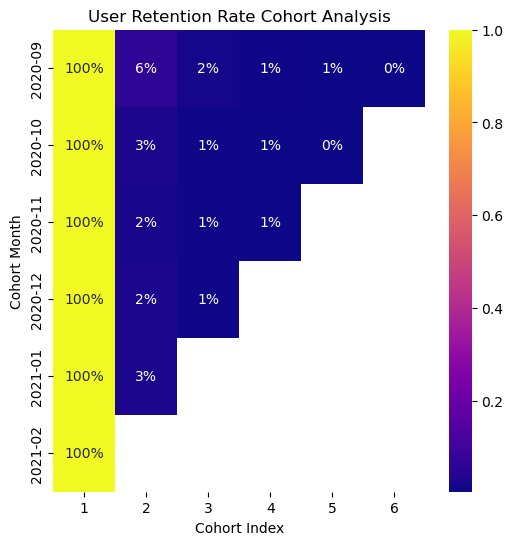

In [62]:
plt.figure(figsize=(6,6))
sns.heatmap(Retention_rate,annot=True,fmt=".0%",cmap="plasma")
plt.title("User Retention Rate Cohort Analysis")
plt.xlabel("Cohort Index")
plt.ylabel("Cohort Month")
plt.show()

In [ ]:
df